In [4]:
import torch
# import wandb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from rich import inspect
from torch.utils.data import random_split
from torchvision .models import resnet18, resnet34, resnet50, resnet101, resnet152
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
from tqdm.notebook import tqdm
import os
from PIL import Image

# MLP code below

In [117]:
!unzip /content/drive/MyDrive/SMAI/double_mnist_seed_123_image_size_64_64.zip

Archive:  /content/drive/MyDrive/SMAI/double_mnist_seed_123_image_size_64_64.zip
replace double_mnist_seed_123_image_size_64_64/val/71/273_71.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [118]:
# PATH = "/content/double_mnist_seed_123_image_size_64_64"

In [5]:
import os

In [5]:
PATH_TRAIN = "/content/double_mnist_seed_123_image_size_64_64/train/"
PATH_VAL =  "/content/double_mnist_seed_123_image_size_64_64/val/"
PATH_TEST =  "/content/double_mnist_seed_123_image_size_64_64/test/"


def load_dataset(path):
    images = []
    labels = []

    for i in os.listdir(path):
        if(int(i) % 11 != 0):
            for file_name in os.listdir(path + i):
                img = Image.open(path + i + "/" + file_name)
                img = np.array(img)
                images.append(img)
                labels.append(int(i))
    images = np.array(images)
    images = images[:, np.newaxis, :, :]

    def one_hot_encode(num, size):
        vec = np.zeros(size)
        vec[(num%size)] = 1
        num = int(num / size)
        vec[(num%size)] = 1
        return vec

    one_hot_encoded_vector = np.empty((0, 10))

    for label in labels:
        if(label % 11 != 0):
            encod = one_hot_encode(label, 10)
            one_hot_encoded_vector = np.vstack([one_hot_encoded_vector, encod])

    return images, one_hot_encoded_vector

In [6]:
# Define hyperparameters
input_size = 64 * 64  # Input image size
hidden_sizes = [256, 128]  # Number of neurons in hidden layers
output_size = 10  # Number of output classes
learning_rate = 0.001
batch_size = 64
epochs = 20

train_img, train_labels = load_dataset(PATH_TRAIN)
test_img, test_labels = load_dataset(PATH_TEST)
val_img, val_labels = load_dataset(PATH_VAL)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_img).float().cuda(), torch.from_numpy(train_labels).cuda())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_img).float().cuda(), torch.from_numpy(test_labels).cuda())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_img).float().cuda(), torch.from_numpy(val_labels).cuda())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

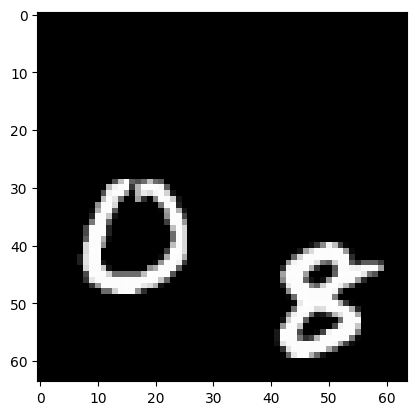

In [7]:
plt.imshow(train_img[0].squeeze(), cmap="gray")

In [8]:
import torch.nn as nn
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Flatten())
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # return F.softmax(self.model(x), dim = 1)
        return self.model(x)


# Initialize and train the model
model = MLPModel(input_size, hidden_sizes, output_size).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(epochs)):
    model.train()

    y_batch = []
    y_pred = []
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)  # CrossEntropyLoss expects class labels
        loss.backward()
        optimizer.step()

        predicted = torch.zeros_like(outputs)
        predicted[outputs >= 0.5] = 1

        y_batch.append(batch_labels)
        y_pred.append(predicted)

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    # print(y_pred.shape)
    print("Training Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))






# Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        y_batch = []
        y_pred = []
        for batch_images, batch_labels in val_loader:
            outputs = model(batch_images)
            predicted = torch.zeros_like(outputs)
            predicted[outputs >= 0.5] = 1
            y_batch.append(batch_labels)
            y_pred.append(predicted)

        y_batch = torch.cat(y_batch)
        y_pred = torch.cat(y_pred)
        # print(y_pred.shape)
        print("Validation Accuracy :")
        print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))



model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    y_batch = []
    y_pred = []
    for batch_images, batch_labels in test_loader:
        outputs = model(batch_images)

        predicted = torch.zeros_like(outputs)
        predicted[outputs >= 0.5] = 1

        y_batch.append(batch_labels)
        y_pred.append(predicted)

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    # print(y_pred.shape)
    print("Test Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))



  0%|          | 0/20 [00:00<?, ?it/s]

Training Accuracy :
0.02517241379310345
Validation Accuracy :
0.004142857142857143
Training Accuracy :
0.053051724137931036
Validation Accuracy :
0.0045
Training Accuracy :
0.06824137931034482
Validation Accuracy :
0.003928571428571429
Training Accuracy :
0.07144827586206896
Validation Accuracy :
0.003142857142857143
Training Accuracy :
0.07022413793103448
Validation Accuracy :
0.003857142857142857
Training Accuracy :
0.06720689655172414
Validation Accuracy :
0.002857142857142857
Training Accuracy :
0.06281034482758621
Validation Accuracy :
0.0014285714285714286
Training Accuracy :
0.06139655172413793
Validation Accuracy :
0.0007857142857142857
Training Accuracy :
0.060086206896551725
Validation Accuracy :
0.002214285714285714
Training Accuracy :
0.05868965517241379
Validation Accuracy :
0.0012857142857142856
Training Accuracy :
0.05989655172413793
Validation Accuracy :
0.0010714285714285715
Training Accuracy :
0.05917241379310345
Validation Accuracy :
0.0015
Training Accuracy :
0.0635

In [9]:
learning_rate = 0.001
kernel_size = 3
dropout_rate = 0.3
batch_size = 64
epochs = 20

train_img, train_labels = load_dataset(PATH_TRAIN)
test_img, test_labels = load_dataset(PATH_TEST)
val_img, val_labels = load_dataset(PATH_VAL)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_img).float().cuda(), torch.from_numpy(train_labels).cuda())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_img).float().cuda(), torch.from_numpy(test_labels).cuda())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_img).float().cuda(), torch.from_numpy(val_labels).cuda())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(9216, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x


In [11]:
class DeeperCNNModel(nn.Module):
    def __init__(self):
        super(DeeperCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Add padding
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Add padding
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Add padding
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Add padding
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # Add padding
        self.bn5 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn7(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [12]:
model = DeeperCNNModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):
    model.train()
    y_batch = []
    y_pred = []
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        predicted = torch.zeros_like(outputs)
        predicted[outputs >= 0.5] = 1
        y_batch.append(batch_labels)
        y_pred.append(predicted)

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    print("Training Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))

    # Evaluate on the validation set
    model.eval()
    y_batch= []
    y_pred = []
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            outputs = model(batch_images)
            predicted = torch.zeros_like(outputs)
            predicted[outputs >= 0.5] = 1

            y_batch.append(batch_labels)
            y_pred.append(predicted)

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    val_accuracy = accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu())
    print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the trained model on the test set
model.eval()
y_batch = []
y_pred = []
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        outputs = model(batch_images)
        predicted = torch.zeros_like(outputs)
        predicted[outputs >= 0.5] = 1

        y_batch.append(batch_labels)
        y_pred.append(predicted)

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)

test_accuracy = accuracy_score(y_true = y_batch.cpu(),y_pred = y_pred.cpu())
print(f"Test Accuracy: {test_accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]

Training Accuracy :
0.43339655172413794
Validation Accuracy: 0.10692857142857143
Training Accuracy :
0.6815344827586207
Validation Accuracy: 0.12907142857142856
Training Accuracy :
0.7447931034482759
Validation Accuracy: 0.12814285714285714
Training Accuracy :
0.8058793103448276
Validation Accuracy: 0.12171428571428572
Training Accuracy :
0.8358103448275862
Validation Accuracy: 0.21285714285714286
Training Accuracy :
0.8777241379310344
Validation Accuracy: 0.32121428571428573
Training Accuracy :
0.8964137931034483
Validation Accuracy: 0.1925
Training Accuracy :
0.9251034482758621
Validation Accuracy: 0.33964285714285714
Training Accuracy :
0.9342758620689655
Validation Accuracy: 0.5518571428571428
Training Accuracy :
0.954103448275862
Validation Accuracy: 0.41964285714285715
Training Accuracy :
0.9597241379310345
Validation Accuracy: 0.5019285714285714
Training Accuracy :
0.9636724137931034
Validation Accuracy: 0.5659285714285714
Training Accuracy :
0.9764137931034482
Validation Accura

# Permuted MNIST

In [13]:
PATH_PERMUTED_MNIST = "/content/drive/MyDrive/SMAI/permuted_mnist.npz"

In [14]:
x = np.load(PATH_PERMUTED_MNIST)
keys = x.keys()
for key in keys:
    print(key)

train_images
train_labels
test_images
test_labels


In [15]:
X_train = x["train_images"]
y_train = x["train_labels"]
X_test = x["test_images"]
y_test = x["test_labels"]

In [16]:
X_train = X_train[:,np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [17]:
X_val.shape

(6000, 1, 28, 28)

In [18]:
trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float().cuda(), torch.from_numpy(y_train).cuda())
testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float().cuda(), torch.from_numpy(y_test).cuda())
valset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float().cuda(), torch.from_numpy(y_val).cuda())

In [19]:
input_size = 28 * 28  # Input image size
hidden_sizes = [256, 128]  # Number of neurons in hidden layers
output_size = 10  # Number of output classes
learning_rate = 0.001
batch_size = 64
epochs = 20

In [33]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [ ]:
model = MLPModel(input_size, hidden_sizes, output_size).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(epochs)):
    model.train()

    y_batch = []
    y_pred = []
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)  # CrossEntropyLoss expects class labels
        loss.backward()
        optimizer.step()
        predicted = outputs
        # print(outputs.shape)
        y_batch.append(batch_labels)
        y_pred.append(np.argmax(predicted.detach().cpu(), axis=1))


    # print(y_batch)
    # print(y_pred)
    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    # print(y_pred.shape)
    # print(y_batch.shape)
    # print(y_pred.shape)
    print("Training Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))






# Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        y_batch = []
        y_pred = []
        for batch_images, batch_labels in val_loader:
            outputs = model(batch_images)
            predicted = outputs
            # print(outputs.shape)
            y_batch.append(batch_labels)
            y_pred.append(np.argmax(predicted.detach().cpu(), axis=1))

        y_batch = torch.cat(y_batch)
        y_pred = torch.cat(y_pred)
        print(y_pred.shape)
        print(y_batch.shape)
        print("Validation Accuracy :")
        print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))



model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    y_batch = []
    y_pred = []
    for batch_images, batch_labels in test_loader:
        outputs = model(batch_images)
        predicted = outputs
        # print(outputs.shape)
        y_batch.append(batch_labels)
        y_pred.append(np.argmax(predicted.detach().cpu(), axis=1))

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    # print(y_pred.shape)
    print("Test Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))



In [52]:
model = model = DeeperCNNModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(epochs)):
    model.train()

    y_batch = []
    y_pred = []
    for batch_images, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)  # CrossEntropyLoss expects class labels
        loss.backward()
        optimizer.step()
        predicted = outputs
        # print(outputs.shape)
        y_batch.append(batch_labels)
        y_pred.append(np.argmax(predicted.detach().cpu(), axis=1))


    # print(y_batch)
    # print(y_pred)
    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(y_pred)
    # print(y_pred.shape)
    # print(y_batch.shape)
    # print(y_pred.shape)
    print("Training Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))






# Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        y_batch = []
        y_pred = []
        for batch_images, batch_labels in val_loader:
            outputs = model(batch_images)
            predicted = outputs
            # print(outputs.shape)
            y_batch.append(batch_labels)
            y_pred.append(np.argmax(predicted.detach().cpu(), axis=1))

        y_batch = torch.cat(y_batch)
        y_pred = torch.cat(y_pred)
        # print(y_pred.shape)
        # print(y_batch.shape)
        print("Validation Accuracy :")
        print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))



model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    y_batch = []
    y_pred = []
    for batch_images, batch_labels in test_loader:
        outputs = model(batch_images)
        predicted = outputs
        # print(outputs.shape)
        y_batch.append(batch_labels)
        y_pred.append(np.argmax(predicted.detach().cpu(), axis=1))

        y_batch.append(batch_labels)
        y_pred.append(predicted)

    y_batch = torch.cat(y_batch)
    y_pred = torch.cat(np.argmax(predicted.detach().cpu(), axis=1))
    # print(y_pred.shape)
    print("Test Accuracy :")
    print(accuracy_score(y_true = y_batch.cpu(), y_pred = y_pred.cpu()))



  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: ignored